<a href="https://colab.research.google.com/github/LuisWG/StockPrediction/blob/master/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

from sklearn import preprocessing
import math
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import matplotlib as mpl
import seaborn as sns
sns.set()

In [0]:
!pip install yfinance --upgrade --no-cache-dir

In [0]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 1, 1)
df_full = pdr.get_data_yahoo("JPM", start, end).reset_index()
df_full.to_csv('JPM.csv',index=False)
df_full.tail()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
2259,2018-12-24,92.889999,94.220001,92.139999,92.139999,90.066071,17009300
2260,2018-12-26,92.690002,95.959999,91.110001,95.959999,93.800095,22542900
2261,2018-12-27,94.820000,97.150002,93.550003,97.040001,94.855774,20304700
2262,2018-12-28,97.949997,98.320000,96.440002,96.830002,94.650513,17963300
2263,2018-12-31,97.589996,98.809998,96.769997,97.620003,95.422729,13237200


In [0]:
df= df_full.copy()
close_px = df['Adj Close']
#Movin Average, not interested yet
#mavg = close_px.rolling(window=100).mean()

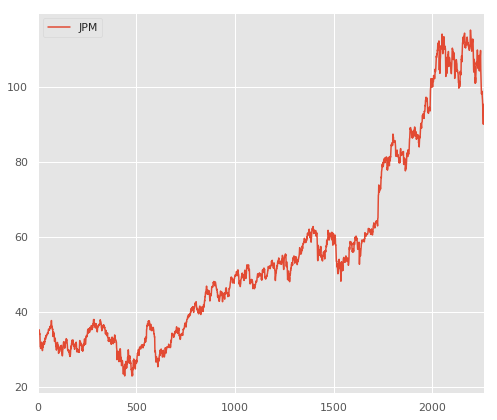

In [0]:
# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='JPM')
#mavg.plot(label='mavg')
plt.legend()

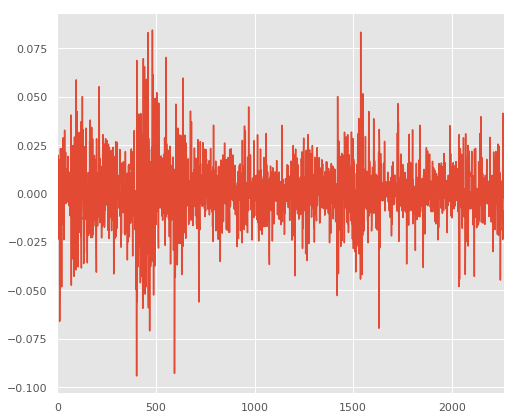

In [0]:
#Returns
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [0]:
#Feature engineering
#High Low Percentage and Percentage Change
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
0,33.765362,35460500,3.080523,2.536485
1,34.419384,41208300,2.426742,2.079923
2,34.608521,27729000,1.775954,1.081696
3,35.294060,44864700,3.371284,2.283626
4,35.207386,33110100,1.387643,0.698673


In [0]:
dfreg = pd.concat([df['Date'],dfreg], axis=1)
dfreg.head()

,Date,Adj Close,Volume,HL_PCT,PCT_change
0,2010-01-04,33.765362,35460500,3.080523,2.536485
1,2010-01-05,34.419384,41208300,2.426742,2.079923
2,2010-01-06,34.608521,27729000,1.775954,1.081696
3,2010-01-07,35.294060,44864700,3.371284,2.283626
4,2010-01-08,35.207386,33110100,1.387643,0.698673


In [0]:
dfreg.set_index('Date', inplace=True)
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,33.765362,35460500,3.080523,2.536485
2010-01-05,34.419384,41208300,2.426742,2.079923
2010-01-06,34.608521,27729000,1.775954,1.081696
2010-01-07,35.294060,44864700,3.371284,2.283626
2010-01-08,35.207386,33110100,1.387643,0.698673


In [0]:
#Stocks Returns Rate and Risk:
#average of returns (Return Rate) and the standard deviation of returns (Risk)
print("Return rate: ", dfreg['Adj Close'].mean(), '\n',"Risk: ", dfreg['Adj Close'].std())

Return rate:  55.73404160909892 
 Risk:  25.177996843572398


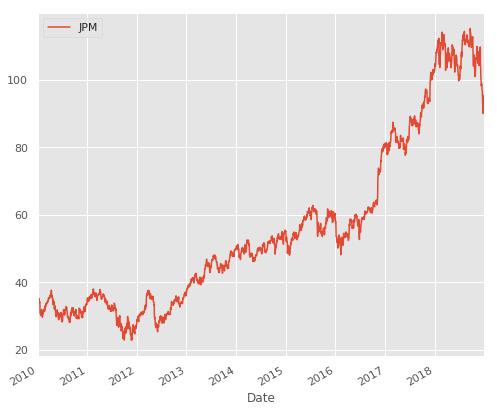

In [0]:
#Lets plot again but now with date as x
close_px1 = dfreg['Adj Close']
# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px1.plot(label='JPM')
#mavg.plot(label='mavg')
plt.legend()

In [0]:
#Import Ta-Lib for further featuring
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

In [0]:
#Further feature Engineering
#arbitrary value for windows & timeperiods n
n=10 
#Relative Strenght index (Momentum descriptor, indicates when a stock has been overbought or under bought)
dfreg['RSI']=talib.RSI(np.array(df['Close']), timeperiod=n)
#Simple Moving Average
dfreg['SMA']=df['Close'].rolling(window=10).mean()
#Correlation
dfreg['Corr']=dfreg['SMA'].rolling(window=n).corr(df['Close'])
#
dfreg['SAR']=talib.SAR(np.array(df['High']),np.array(df['Low']),0.2,0.2)
#Average Directional Movement Index (Momentum Indicators)
dfreg['ADX']=talib.ADX(np.array(df['High']),np.array(df['Low']),np.array(df['Close']), timeperiod=n)
#
dfreg['Return']=np.log(df['Open']/df['Open'].shift(1))

In [0]:
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change,RSI,SMA,Corr,SAR,ADX,Return
Date,,,,,,,,,,
2018-12-24,90.066071,17009300,2.257437,-0.807407,14.897847,NaN,NaN,99.202002,41.165421,NaN
2018-12-26,93.800095,22542900,5.054187,3.527885,34.859197,NaN,NaN,98.430000,41.570276,NaN
2018-12-27,94.855774,20304700,3.709809,2.341279,39.329583,NaN,NaN,91.110001,40.655446,NaN
2018-12-28,94.650513,17963300,1.941545,-1.143435,38.754978,NaN,NaN,91.110001,38.669627,NaN
2018-12-31,95.422729,13237200,2.089737,0.030748,42.279867,NaN,NaN,92.552001,36.408304,NaN


In [0]:
#frther cleaning
missing_data = dfreg.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")    
#dfreg.dropna()

Adj Close
False    2264
Name: Adj Close, dtype: int64

Volume
False    2264
Name: Volume, dtype: int64

HL_PCT
False    2264
Name: HL_PCT, dtype: int64

PCT_change
False    2264
Name: PCT_change, dtype: int64

RSI
False    2254
True       10
Name: RSI, dtype: int64

SMA
True    2264
Name: SMA, dtype: int64

Corr
True    2264
Name: Corr, dtype: int64

SAR
False    2263
True        1
Name: SAR, dtype: int64

ADX
False    2245
True       19
Name: ADX, dtype: int64

Return
True    2264
Name: Return, dtype: int64



In [0]:
dfreg.drop('SMA','Return',inplace=True)
dfreg['SMA']=df['Close'].rolling(window=100).mean()

In [0]:
#Correlation Analysis with all engineered featured 
retscomp = dfreg.pct_change()
corr = retscomp.corr()
corr

,Adj Close,Volume,HL_PCT,PCT_change,RSI,SMA,Corr,SAR,ADX,Return
Adj Close,1.000000,-0.116611,-0.120443,0.046655,0.832054,NaN,NaN,-0.330868,-0.023109,NaN
Volume,-0.116611,1.000000,0.558487,-0.026883,-0.140239,NaN,NaN,0.044311,0.126673,NaN
HL_PCT,-0.120443,0.558487,1.000000,-0.078745,-0.129424,NaN,NaN,0.030400,0.087138,NaN
PCT_change,0.046655,-0.026883,-0.078745,1.000000,0.034128,NaN,NaN,-0.028395,0.025971,NaN
RSI,0.832054,-0.140239,-0.129424,0.034128,1.000000,NaN,NaN,-0.344713,-0.021293,NaN
SMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Corr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAR,-0.330868,0.044311,0.030400,-0.028395,-0.344713,NaN,NaN,1.000000,-0.029387,NaN
ADX,-0.023109,0.126673,0.087138,0.025971,-0.021293,NaN,NaN,-0.029387,1.000000,NaN
Return,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'RSI')

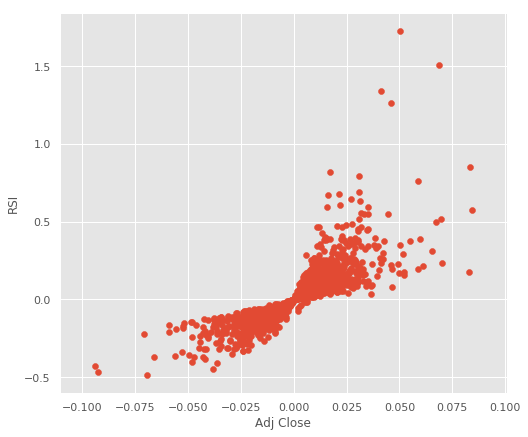

In [0]:
#Correlation explored
plt.scatter(retscomp['RSI'],retscomp['Adj Close'])
plt.xlabel('RSI')
plt.ylabel('Adj Close')

In [0]:
#We have all 2019 to test the model, so lets use all data to train
#We will try with QDA, SVR, and MLPRegressor

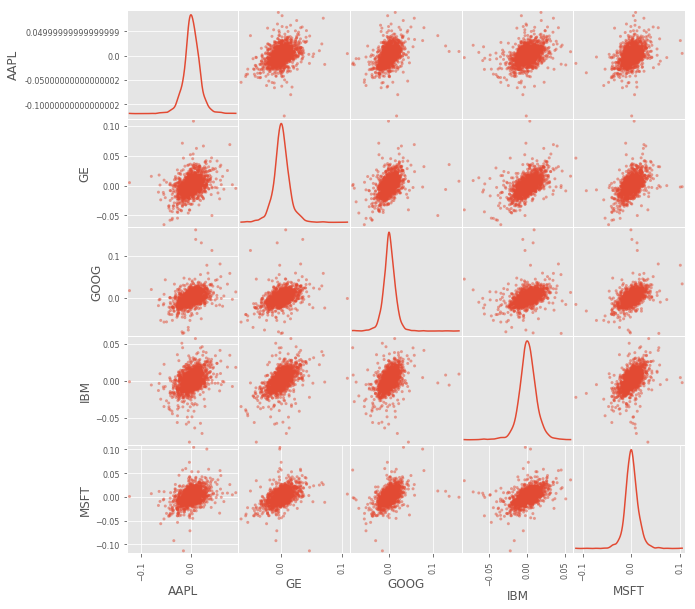

In [0]:
#visualization on correlation
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

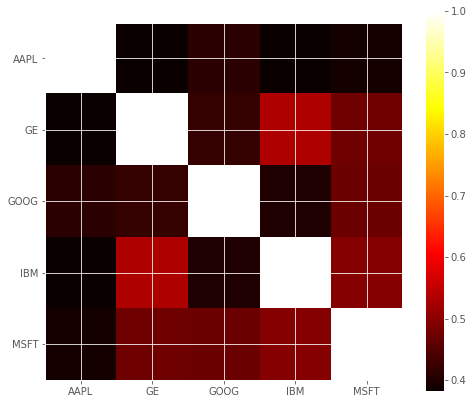

In [0]:
#Prove positive correlation (heatmap)
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

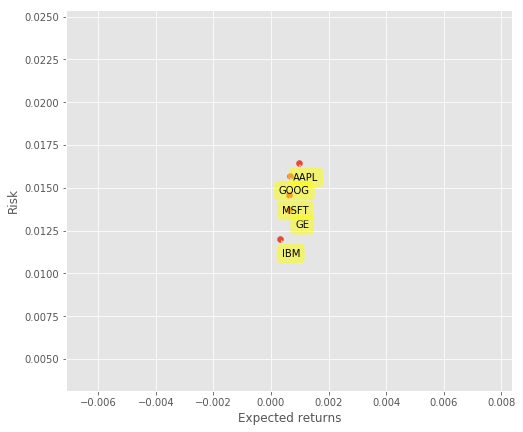

In [0]:
#Stocks Returns Rate and Risk:
#average of returns (Return Rate) and the standard deviation of returns (Risk)
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [0]:
#Feature engineering
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,26.681330,123432400.0,0.990606,0.271752
2010-01-05,26.727465,150476200.0,1.091520,-0.102519
2010-01-06,26.302330,138040000.0,2.123523,-1.590633
2010-01-07,26.253704,119282800.0,1.400893,-0.552538
2010-01-08,26.428249,111902700.0,1.386924,0.798864


In [0]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
Y_lately = y[-forecast_out:]
y = y[:-forecast_out]
X.shape

(1751, 4)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [0]:
from sklearn.model_selection import train_test_split


X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",X_train.shape[0])

number of test samples : 263
number of training samples: 1488


In [0]:
#MY TRAINING DATASETS
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, Y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, Y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [0]:
#TRYING TO MAKE SENCE OF THE VARIABLES IN TDS
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X, y)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X, y)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [0]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [0]:
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x="Date", y="price", data=dfreg)
plt.ylim(0,)

In [0]:
#MY ERROR
confidencereg = clfreg.score(x_test, y_test)
confidencepoly2 = clfpoly2.score(x_test,y_test)
confidencepoly3 = clfpoly3.score(x_test,y_test)
confidenceknn = clfknn.score(x_test, y_test)
print(confidencereg, confidencepoly2, confidencepoly3, confidenceknn)

0.9665304978619643 0.9672931377842097 0.9676552448217303 0.9848820954938056


In [0]:
#STILL GET ERROR FROM TDS
confidencereg = clfreg.score(X_lately, Y_lately)
confidencepoly2 = clfpoly2.score(X_lately,Y_lately)
confidencepoly3 = clfpoly3.score(X_lately,Y_lately)
confidenceknn = clfknn.score(X_lately, Y_lately)
print(confidencereg, confidencepoly2, confidencepoly3, confidenceknn)

ValueError: ignored

In [0]:
forecastreg_set = clfreg.predict(X_lately)
forecastpoly2_set = clfpoly2.predict(X_lately)
forecastply3_set = clfpoly3.predict(X_lately)
forecastknn_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecastreg_set, forecastpoly2_set, forecastply3_set, forecastknn_set ) 

[110.75307166 110.70111856 111.94099515 112.05472703 112.02393045
 111.3807638  111.84188342 112.58367324 112.31433457 111.94596098
 111.23604287 111.4636572  111.1916627  111.80734479 113.02485667
 113.89113755 114.05411603 114.6488055 ] [109.49597883 109.26294555 111.4341369  111.39997266 111.12752995
 110.64939094 111.59054152 112.27331855 112.40464887 111.55198931
 110.97476985 110.98638129 110.63801952 111.24989819 112.17587632
 112.70873147 113.11297545 113.55154836] [109.56238158 108.06402813 111.17837191 110.6380552  110.24413385
 109.8026042  111.30754929 111.85127006 111.64229846 110.83938111
 110.30698078 110.68626859 109.93624036 110.88683018 111.90528083
 112.41129868 112.30085879 113.0332587 ] [110.34494019 112.58226395 103.22626877 102.95124817 108.24702454
 103.98313904 108.75272369 112.76696777 102.93068314 108.24702454
 102.93068314 108.41541672 106.88648987 108.75272369 116.62772369
 114.43230438 102.95124817 112.71194077]


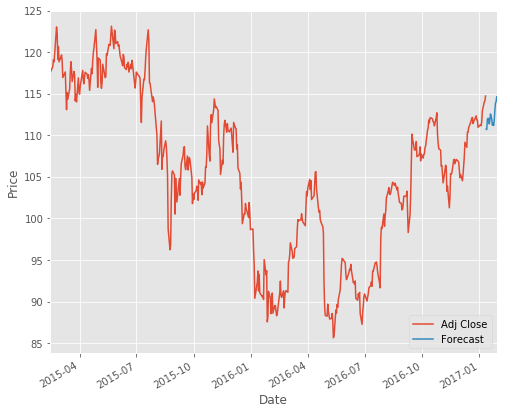

In [0]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecastreg_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()